In [1]:
using DrWatson

@quickactivate

In [2]:
# so we can keep adding packages to the venv
"""using Pkg
Pkg.add("Cthulhu")"""

"using Pkg\nPkg.add(\"Cthulhu\")"

In [ ]:
using CairoMakie
using SparseArrays
using LinearAlgebra
using Statistics
using Distributed
# optimization tools
using Profile, ProfileSVG
using JET
using Cthulhu



In [ ]:
using QuantumToolbox
using ITensors, ITensorMPS


"""# this is for compiling an itensor image so when we start it does not take ages to 
# comile the pakages. This only needs to be run onces per kernel or when you update the packages
# to create the sys_itensor.so image

using PackageCompiler

ITensors.compile()

# To load the image in a jupyter notebook:
# using IJulia
# installkernel("julia_ITensors","--sysimage=~/.julia/sysimages/sys_itensors.so")
# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json
# "--sysimage ~/.julia/sysimages/sys_itensors.so"
"""

# Exact Diagonalization

In [5]:
N = 3 # local hilbert space dimension
L = 6 # size of the chain
ω = 0 # frequency of the harmonic oscillator
J = 1.0 # hopping
γ = 0.1 # damping rate
maxt = 30.0 # maximum time
tlist = range(0, maxt, 200) # time list for exact diago

0.0:0.1507537688442211:30.0

In [6]:
# annihilation operator list
aj_list = []
a = destroy(N) # annihilation operator

# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)
# Create the annihilation opeartors at each lattice site
for i in range(1,L)
    local_list = fill(Id,L)
    local_list[i] = a
    # annihilation acting on j
    push!(aj_list,tensor(local_list ...));
end


In [7]:
# create the hamiltonian
H = ω*aj_list[1]' * aj_list[1] 

for i in range(2,L)
    H+= ω*aj_list[i]' * aj_list[i]  + J* (aj_list[i-1]' * aj_list[i]+ aj_list[i]' * aj_list[i-1])
end


In [ ]:
# create initial state
s_list = fill(fock(N,0),L)
s_list[1] = fock(N,1)
# ψ0 = tensor(fock(L, 2),fock(L,0),fock(L,0)) # initial state

ψ0 = tensor(s_list...); # initial state

In [ ]:

# c_ops = [sqrt(γ) * aj_list[end]]
c_ops = sqrt(γ) .* aj_list
e_ops = [aj_list[1]' * aj_list[1], aj_list[end]' * aj_list[end]]

result = mesolve(H, ψ0, tlist, c_ops, e_ops = e_ops)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


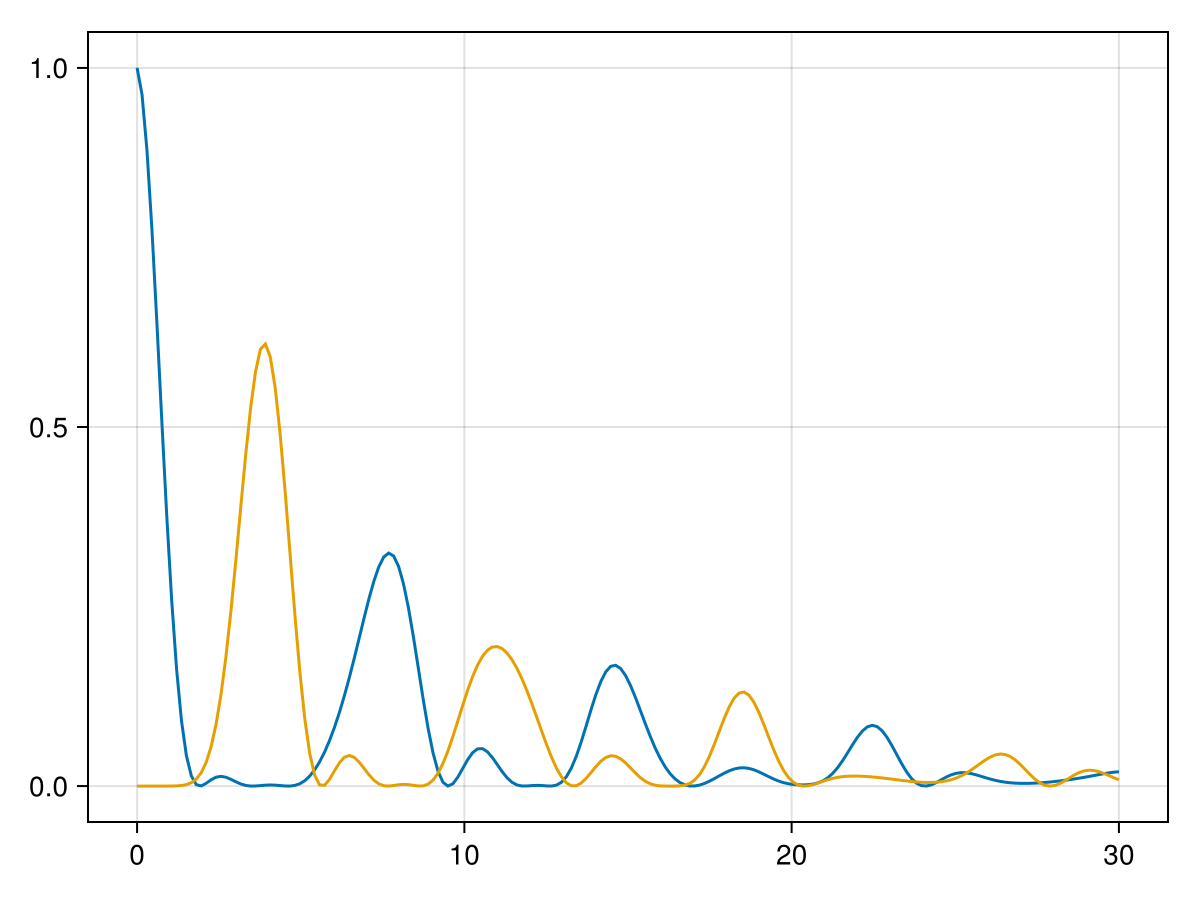

In [10]:
f = Figure()
ax = Axis(f[1, 1])

lines!(tlist, real(result.expect[1,1:end]))
lines!(tlist, real(result.expect[2,1:end]))

f

# Open System MPS

Using trajectories as shown in https://www.scipost.org/10.21468/SciPostPhys.15.4.152

In [ ]:
function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end


function ask_where(intervals)
    # decide where to project the staet when there is a jump, each element in intervals is associated to
    # a jump operator
    r2 = rand()
    dummy = 0
    j = 1
    found_site = -1
    while dummy == 0
        if r2<sum(intervals[1:j])
            dummy = 1
            found_site = j
        else 
            j = j+1
        end
    end
    return found_site
end

function build_TEBD(L, J, Δτ, Nh, γ)
    gammas = zeros(L) # list for where the dissipations act
    gammas[1:end] .= γ 
    #  build site indices
    s = siteinds("Boson", L; dim=Nh, conserve_qns=false)
    # build the time evol gates for TEBD
    gates = ITensor[]
    for j in 1:(L-1)
        s1 = s[j]
        s2 = s[j+1] 
         # for the last site

        hj = op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1) - 0.5*im * gammas[j]*op("n",s1)*op("Id",s2)
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)
    end

    hj = - 0.5*im*gammas[end]*op("Id",s[end-1])*op("n",s[end])
    Gj = exp(-im * Δτ/2 * hj)
    push!(gates, Gj)
    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))

    return s, gates

end

function compute_trajectory(s::Vector{Index{Int64}}, gates::Vector{ITensor}, L::Int64, J::Float64,
                             Δτ::Float64, ttotal::Float64, Nh::Int64, γ::Float64, cutoff::Float64)
    # bettwe to put it in a function to avoid the global julia scope
    """ 
    s = indices for truncation
    Gj = TEBD circuit for one step
    L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension
    gamma = dissipation
    """

    n_tsteps = round(Int64, ttotal/Δτ)+1
    gammas = zeros(L) # list for where the dissipations act
    gammas[1:end] .= γ # for now only dissipation at the end of the chain
    occupations = Vector{Vector{Float64}}(undef, n_tsteps)
    corr_matrices = Vector{Matrix{ComplexF64}}(undef, n_tsteps)
    entropies = zeros(n_tsteps)
    bond_dimensions = zeros(Int, n_tsteps)
    
    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "1"
    psi = MPS(s, state_list)
    psi_cand = copy(psi) # candidate for new state}

    dummy_counter = 1

    for t in 0.0:Δτ:ttotal
        # keep track of the occupations at each time step
        occ = ITensorMPS.expect(psi,"N")        
        # entanglement entropy between two equal sized parts of the chain
        print
        Svn = entangement_S(psi, round(Int64, L/2))
        occupations[dummy_counter] = occ
        corr_matrices[dummy_counter] = correlation_matrix(psi,"adag","a")
        entropies[dummy_counter] = Svn
        bond_dimensions[dummy_counter] = ITensorMPS.maxlinkdim(psi)

        t≈ttotal && break

        # metropolis step
        psi_cand = apply(gates, psi; cutoff) # candidate for new state}
        norm = inner(psi_cand',psi_cand)
        proba_act = real(1 - norm)
        r1 = rand()
        if r1 > proba_act
            # here no jump so we accept the state
            psi = psi_cand/norm
        else
            # jump, so choose which state we project to
            δp_list = [gammas[i]*ITensorMPS.expect(psi,"N",sites=i) for i in 1:L]  
            normalize!(δp_list)
            jump_site = ask_where(δp_list)
            jump_op = sqrt(gammas[jump_site])*op("a",s[jump_site]);
            psi = apply(jump_op , psi)
            normalize!(psi)
        end

        dummy_counter+=1
    end

    return occupations, entropies, bond_dimensions, corr_matrices
end

let
    s_indices, gates = build_TEBD(L, J,tlist[2]-tlist[1], N, γ)
    @time compute_trajectory(s_indices, gates, L, J,tlist[2]-tlist[1], 10.0, N, γ,1*10^(-15))
end

  0.729175 seconds (2.17 M allocations: 447.203 MiB, 16.77% gc time, 1.61% compilation time)


([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.977571622743273, 0.022301665975891293, 0.0001259954131013304, 7.118234993521898e-7, 4.0212572015838624e-9, 2.2977537872083535e-11], [0.912782943479558, 0.08523972674311743, 0.0019521515707918652, 2.492509124874713e-5, 2.5086231262887615e-7, 2.252971636995764e-9], [0.812733859422026, 0.17768190477443518, 0.009341082729491567, 0.00023898908125695245, 4.10703502881261e-6, 5.69577613797984e-8], [0.6880375455100154, 0.2834746167705779, 0.02725131182692398, 0.001202888650068046, 3.2954379189302065e-5, 6.828632252049033e-7], [0.5512302446384646, 0.3845091444345807, 0.05995245723945084, 0.004134119838479209, 0.00016899573881206547, 5.038110212659197e-6], [0.41496787576654753, 0.46407085870698345, 0.10927919592707298, 0.011017905780186082, 0.0006377458621157545, 2.6417957094046867e-5], [0.2903251648733982, 0.509789712735288, 0.17342637043415637, 0.02442769384006808, 0.0019234977608353656, 0.00010756035625441575], [0.18547868985609425, 0.5156167341240667, 0.2

In [117]:
"""report = @report_opt ignored_modules=([ITensorMPS, ITensors]) compute_trajectory(s_indices, gates, L, J,tlist[2]-tlist[1], 10, N, γ,1*10^(-15))
rpts = JET.get_reports(report);"""

"report = @report_opt ignored_modules=([ITensorMPS, ITensors]) compute_trajectory(s_indices, gates, L, J,tlist[2]-tlist[1], 10, N, γ,1*10^(-15))\nrpts = JET.get_reports(report);"

In [ ]:

# Do an ensemble average over all trajectories to get the actual occupatinos
N_trajectories = 50
cutoff = 1*10^(-18)
Delta_t = 0.3
time_list = 0.0:Delta_t:maxt

occupation_ensemble = Vector{Matrix{Float64}}(undef, N_trajectories)
correlation_ensemble = Vector{Vector{Matrix{ComplexF64}}}(undef, N_trajectories)
entropy_ensemble = zeros(N_trajectories, length(time_list))
b_dims_ensemble = zeros(N_trajectories, length(time_list))

s_indices, gates = build_TEBD(L, J,Delta_t, N, γ)

Threads.@threads for traj in 1:N_trajectories
    occupations, Svns, bond_dim, correlation_matrix = compute_trajectory(s_indices, gates, L, J,
                                                            Delta_t, maxt, N, γ, cutoff);
    occupations = reduce(hcat, occupations);
    occupation_ensemble[traj] = occupations
    entropy_ensemble[traj, 1:end] = Svns
    b_dims_ensemble[traj, 1:end] = bond_dim
    correlation_ensemble[traj] = correlation_matrix
end

In [ ]:
println(length(time_list))

mean_traj = mean(occupation_ensemble)
mean_entropy = mean(entropy_ensemble,dims=1)[1,1:end]
mean_bond = mean(b_dims_ensemble,dims=1)[1,1:end]
tot_oc = sum(mean_traj, dims=1)[1:end]
mean_corr = mean(correlation_ensemble);

121


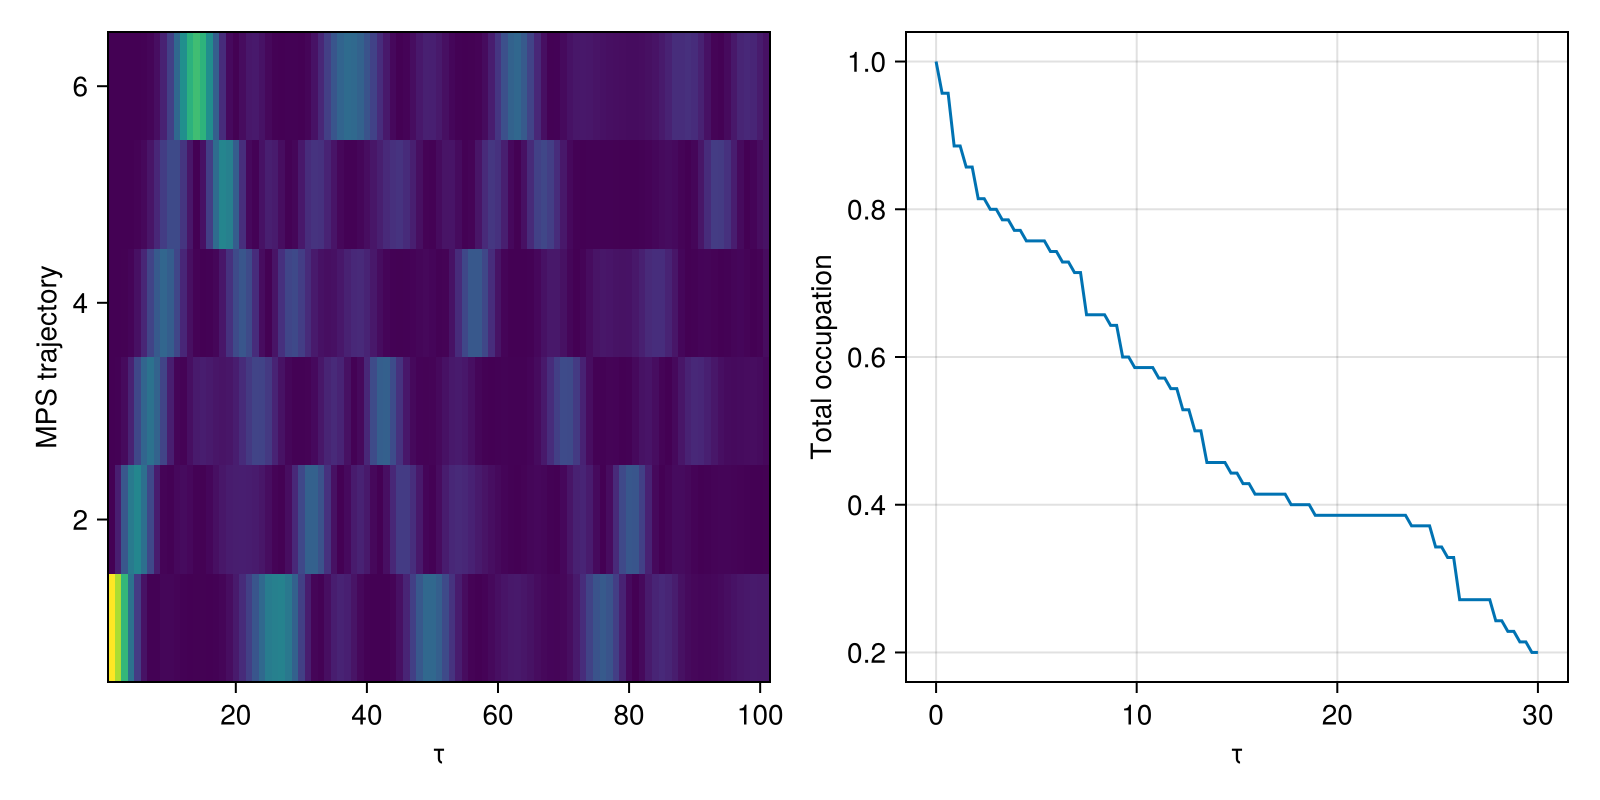

In [177]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="MPS trajectory")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Total occupation")

heatmap!(ax1, transpose(mean_traj))
lines!(ax2, time_list, tot_oc)

f 


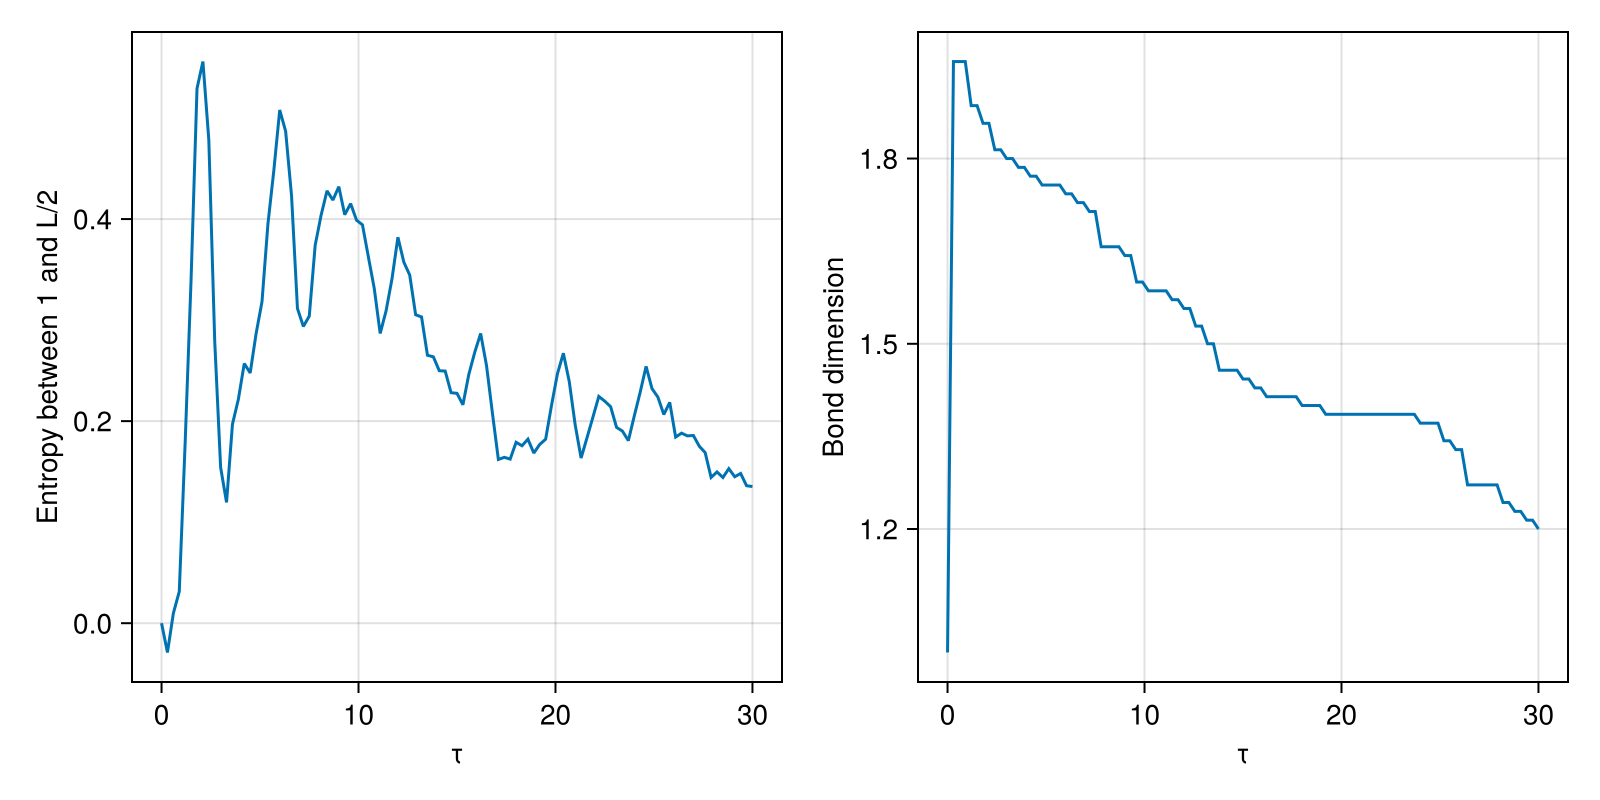

In [178]:
f= Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Entropy between 1 and L/2")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Bond dimension")


lines!(ax1, time_list, mean_entropy)
lines!(ax2, time_list, mean_bond)

f

In [180]:
shape(mean_corr[1])
# don0t forget the normalziattion factor
tindex = 10
Ct1 = mean_corr[tindex][1,1:end]/sqrt(mean_corr[tindex][1,1]*mean_corr[tindex][end,end])

Ctf = mean_corr[end][1,1:end]/sqrt(mean_corr[end][1,1]*mean_corr[end][end,end])
abs.(Ctf)

6-element Vector{Float64}:
 1.2168177848381272
 0.14008967215854112
 0.6352178504293025
 0.8297252137023782
 1.0306595863546173
 0.9999999999999998

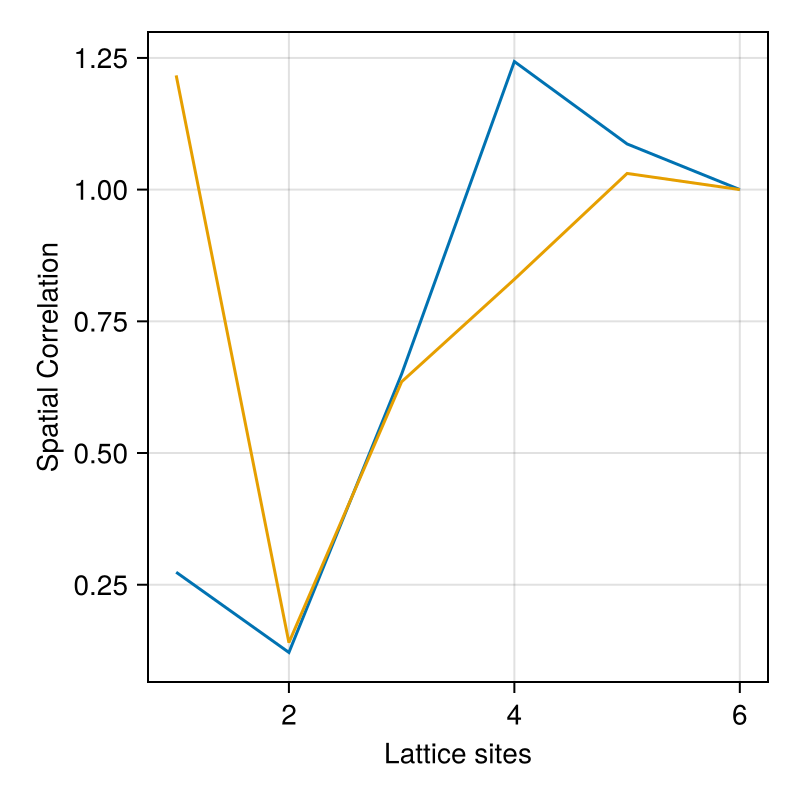

In [181]:
f = Figure(size = (400, 400))
ax1 = Axis(f[1, 1], xlabel="Lattice sites", ylabel="Spatial Correlation")

lines!(abs.(Ct1))
lines!(abs.(Ctf))

f

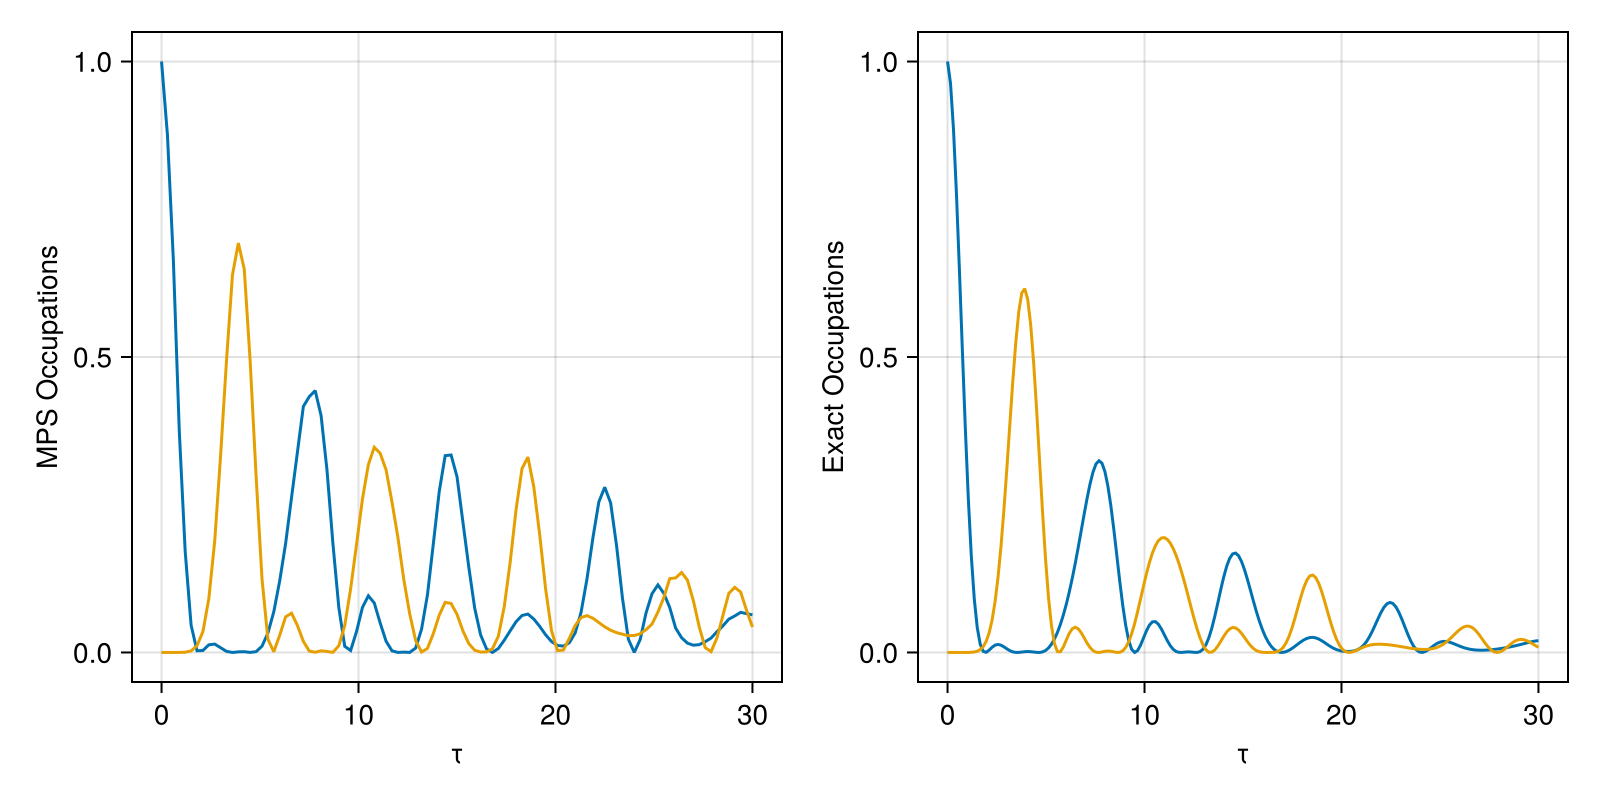

In [182]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

lines!(ax1, time_list, mean_traj[1,1:end])
lines!(ax1, time_list, mean_traj[end,1:end])

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))

f

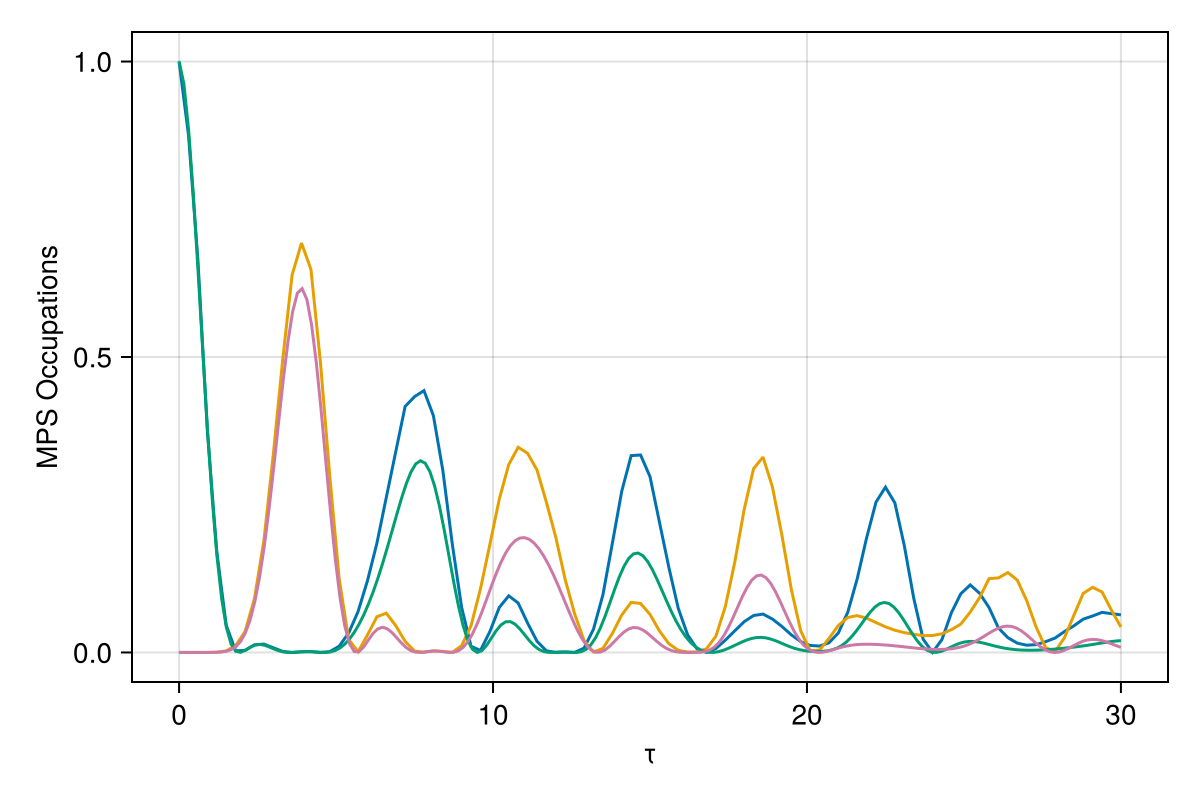

In [183]:
f = Figure(size = (600, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")

lines!(ax1, time_list, mean_traj[1,1:end])
lines!(ax1, time_list, mean_traj[end,1:end])

lines!(ax1, tlist, real(result.expect[1,1:end]))
lines!(ax1, tlist, real(result.expect[2,1:end]))

f

# Closed MPS 

In [20]:

function main_TN(L, J, Δτ, ttotal, Nh, cutoff=1E-8  )
    # bettwe to put it in a function to avoid the global julia scope
    """ L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension"""

    occupations = []
    times = []
    entropies = []
    #  build site indices
    s = siteinds("Boson", L; dim=Nh, conserve_qns=true)
    # build the time evol gates for TEBD
    gates = ITensor[]
    for j in 1:(L-1)
        s1 = s[j]
        s2 = s[j+1] 
        hj = op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1)
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)

    end
    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))
    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "2"
    psi = MPS(s, state_list)

    for t in 0.0:Δτ:ttotal

        # keep track of the occupations at each time step
        occ = ITensorMPS.expect(psi,"N")
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, Integer(L/2))
        push!(occupations, occ)
        push!(times, t)
        push!(entropies, Svn)

        t≈ttotal && break

        psi = apply(gates, psi; cutoff)
        normalize!(psi)
    end
    return occupations, times, entropies
end


main_TN (generic function with 2 methods)

In [21]:
Occupations, times, Svns = main_TN(L, J,tlist[2]-tlist[1], maxt,N);
Occupations = reduce(hcat, Occupations)


6×200 Matrix{Float64}:
 2.0  1.95514      1.82556     1.62546     …  0.707346   0.740858   0.761734
 0.0  0.0446028    0.170476    0.355352       0.0231656  0.0117834  0.0025923
 0.0  0.000252907  0.00391111  0.0187026      0.353149   0.277      0.194692
 0.0  1.4424e-6    5.03285e-5  0.00048081     0.0553455  0.161022   0.316408
 0.0  0.0          3.92439e-7  7.86632e-6     0.253954   0.322169   0.352443
 0.0  0.0          0.0         6.75258e-8  …  0.607039   0.487168   0.372131

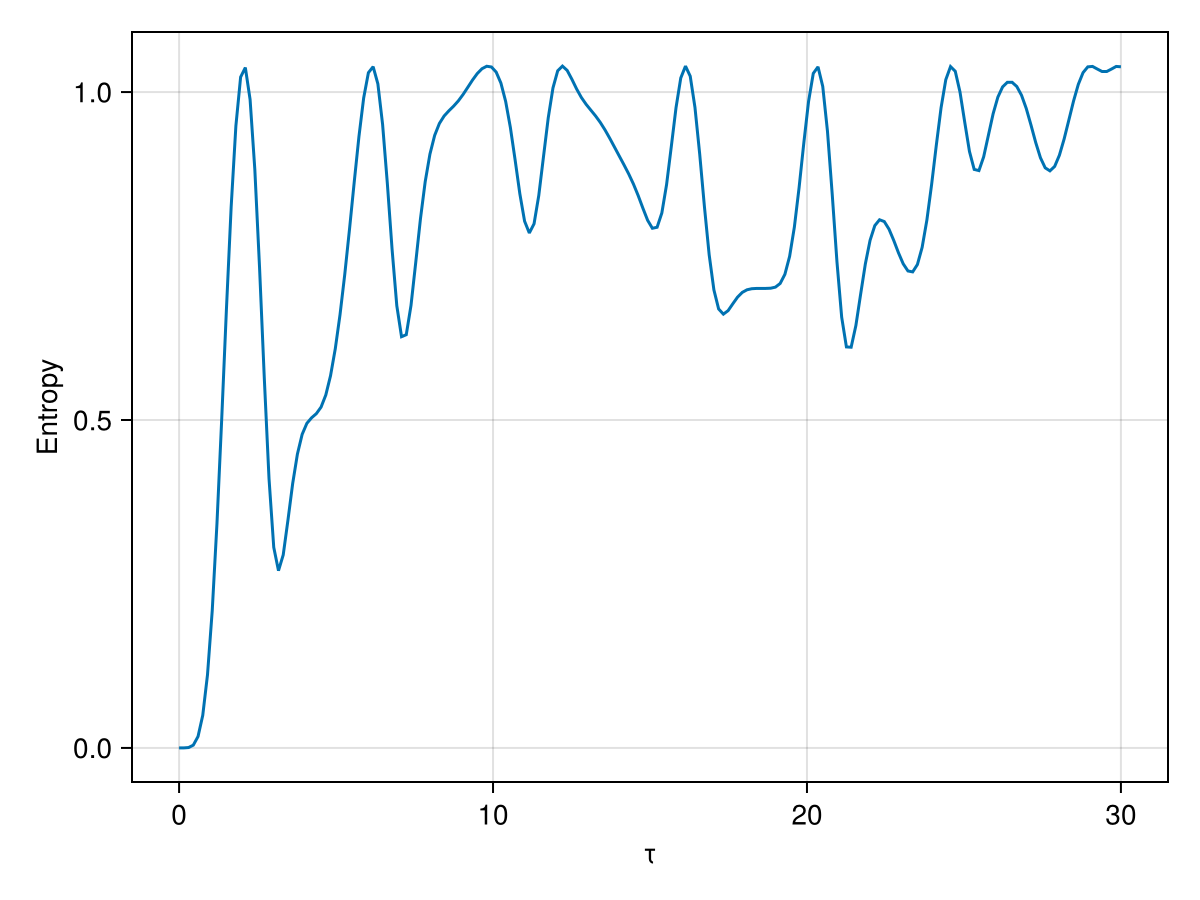

In [22]:
f = Figure()
ax = Axis(f[1, 1], xlabel="τ", ylabel="Entropy")

lines!(times, Svns)
f

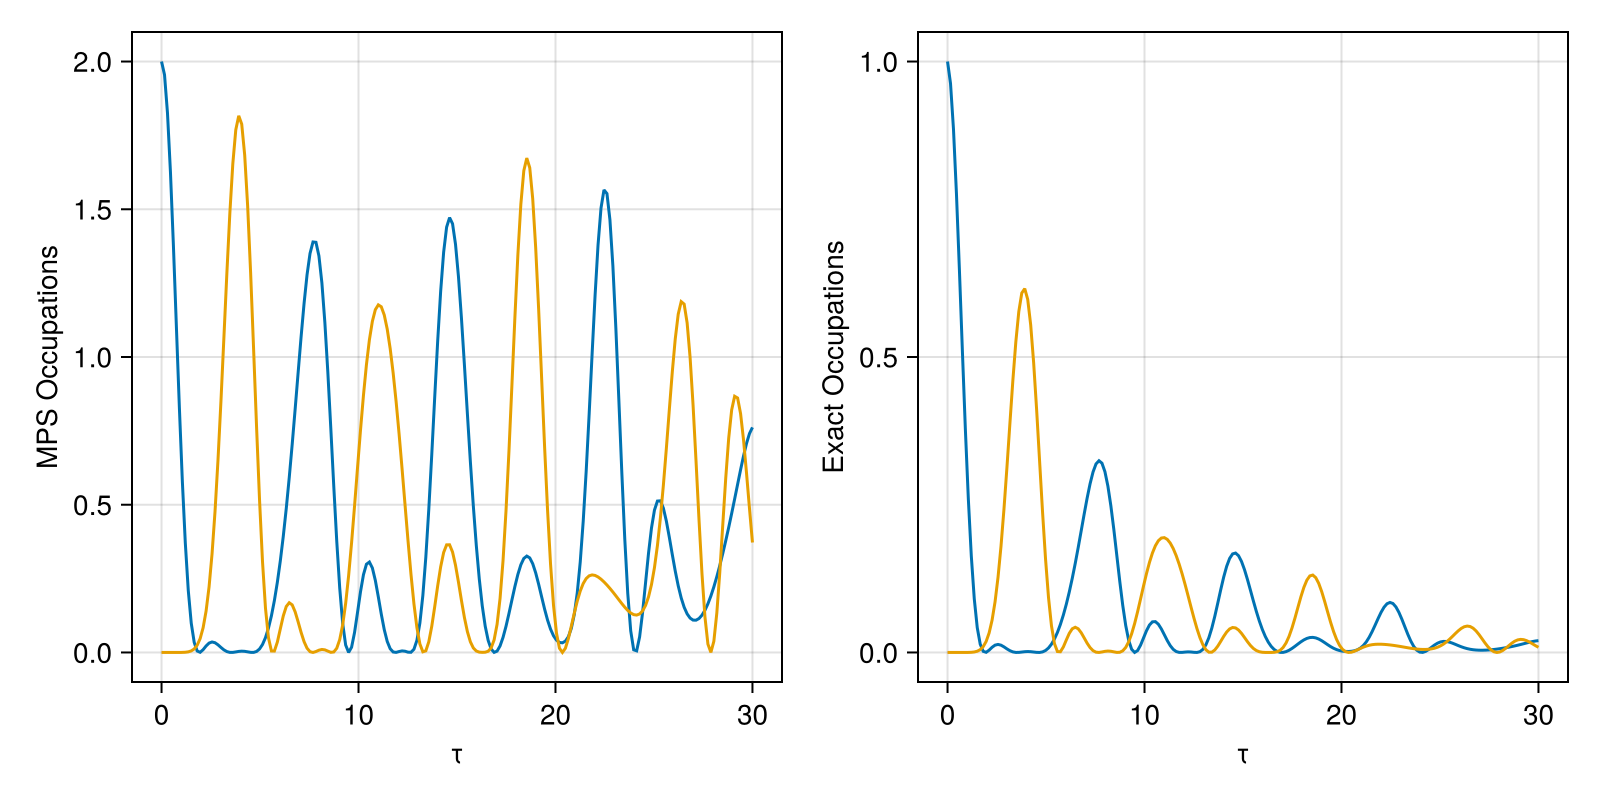

In [23]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

lines!(ax1, times, Occupations[1,1:end])
lines!(ax1, times, Occupations[end,1:end])

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))
f
